In [1]:
from load_LungAmbition3D_test_data_binary import load_lungAmbition
import numpy as np
import pandas as pd
import os
import ast

keep_false_positives_as_separate_test = True

df_merged = pd.read_csv('/home/ubuntu/tenerife/data/LungAmbition/Excels_merged/LungAmbitionMergedAllGroupUpdated3mar2025.csv')
# filter df_merged by GroupUpdated to keep only Lung_Cancer, Benign_Nodules and False_Positive
df_merged = df_merged[df_merged['GroupUpdated'].isin(['Lung_Cancer', 'Benign_Nodules', 'False_Positive'])]
df_merged = df_merged[['ID_proteinData', 'Group', 'Stage_category', 'NRRD_File', 'SEG_Files', 'Cancer_Status', 'TimeYears_CT_blood']]
df_merged['SEG_Files'] = df_merged['SEG_Files'].apply(ast.literal_eval)
if keep_false_positives_as_separate_test:
    y_false_positives = df_merged[df_merged['Group'] == 'False_Positive']['Group']
    # convert label to 1
    y_false_positives = y_false_positives.replace({'False_Positive': 0})
    ID_false_positives = df_merged[df_merged['Group'] == 'False_Positive']['ID_proteinData']
    # create list to store wrong predicted false positives
    list_ID_wrong_predicted_false_positives = []
    X_false_positives = df_merged[df_merged['Group'] == 'False_Positive'].drop(columns=['ID_proteinData', 'Group'])
    # drop in df_cur rows where Group is False_Positive
    df_merged = df_merged[df_merged['Group'].isin(['Lung_Cancer', 'Benign_Nodules'])]
    print("Number of false positives:", X_false_positives.shape[0])
    # save false_positive_metrics in df
    false_positive_metrics = pd.DataFrame(columns=['Fold', 'AUC', 'Balanced_accuracy', 'Accuracy', 'Precision', 'Recall', 'F1-score'])
else:
    df_merged = df_merged[df_merged['Group'].isin(['Lung_Cancer', 'Benign_Nodules', 'False_Positive'])]
    # print shape of excel
    print("Dimensions excel after dropping rows where Group is False_Positive:", df_merged.shape)
# assert that Cancer_Status is 1 for patients where TimeYears_CT_blood is 0 and
# Cancer_Status is 0 for patients where TimeYears_CT_blood is 5
assert (df_merged.loc[df_merged["TimeYears_CT_blood"] == 0, "Cancer_Status"] == 1).all(), \
    "There are patients with TimeYears_CT_blood = 0 who do not have Cancer_Status = 1"
assert (df_merged.loc[df_merged["TimeYears_CT_blood"] == 5, "Cancer_Status"] == 0).all(), \
    "There are patients with TimeYears_CT_blood = 5 who do not have Cancer_Status = 0"
# define a new malignancy column, if Cancer_Status is 0, then malignancy is 0, else 1 according to proposed method
df_merged['Malignancy'] = df_merged['Cancer_Status'].apply(lambda x: 0 if x == 0 else 1)
# save best metrics for each fold
fold_metrics_df = pd.DataFrame(columns=['Fold', 'AUC', 'Accuracy', 'Bal_accuracy', 'Specificity', 'Precision', 'Recall', 'F1-score' 'NPV', 'PPV'])
path_to_folds_csv = f'/home/ubuntu/tenerife/data/ZZ_githubRepos/LungAmbition/Data_stratified_split/folds-def_{3}folds'
for fold in range(0, 1):
    print("=" * 80)
    print(f"Fold {fold + 1}:")
    # read train, test and val indices for each fold
    fold_data = pd.read_csv(os.path.join(path_to_folds_csv, f'id2splitfold_{fold}.csv'))
    train_index = fold_data[fold_data['split'] == 'train']['ID_proteinData']
    test_index = fold_data[fold_data['split'] == 'test']['ID_proteinData']
    val_index = fold_data[fold_data['split'] == 'val']['ID_proteinData']
    # get first train, text, val, then split into X_train, X_test, X_val and y_train, y_test, y_val
    train = df_merged.loc[df_merged['ID_proteinData'].isin(train_index)]
    test = df_merged.loc[df_merged['ID_proteinData'].isin(test_index)]
    val = df_merged.loc[df_merged['ID_proteinData'].isin(val_index)]
    # print number of samples in train, val and test for Malignancy 0 and 1
    print("Train, total benign nodules", train[train['Malignancy'] == 0].shape[0], "lung cancer", train[train['Malignancy'] == 1].shape[0])
    print("Val, total benign nodules", val[val['Malignancy'] == 0].shape[0], "lung cancer", val[val['Malignancy'] == 1].shape[0])
    print("Test, total benign nodules", test[test['Malignancy'] == 0].shape[0], "lung cancer", test[test['Malignancy'] == 1].shape[0])

    train_loader = load_lungAmbition(train, batch_size=4, spatial_size=[64, 64, 64], shuffle=False, type_processing = None, augment_prob=1)
    # val_loader = load_lungAmbition(val, batch_size=2, spatial_size=[64, 64, 64], shuffle=False, type_processing = None)
    # test_loader = load_lungAmbition(test, batch_size=2, spatial_size=[64, 64, 64], shuffle=False, type_processing = None)
        

Number of false positives: 5
Fold 1:
Train, total benign nodules 40 lung cancer 18
Val, total benign nodules 5 lung cancer 2
Test, total benign nodules 23 lung cancer 11


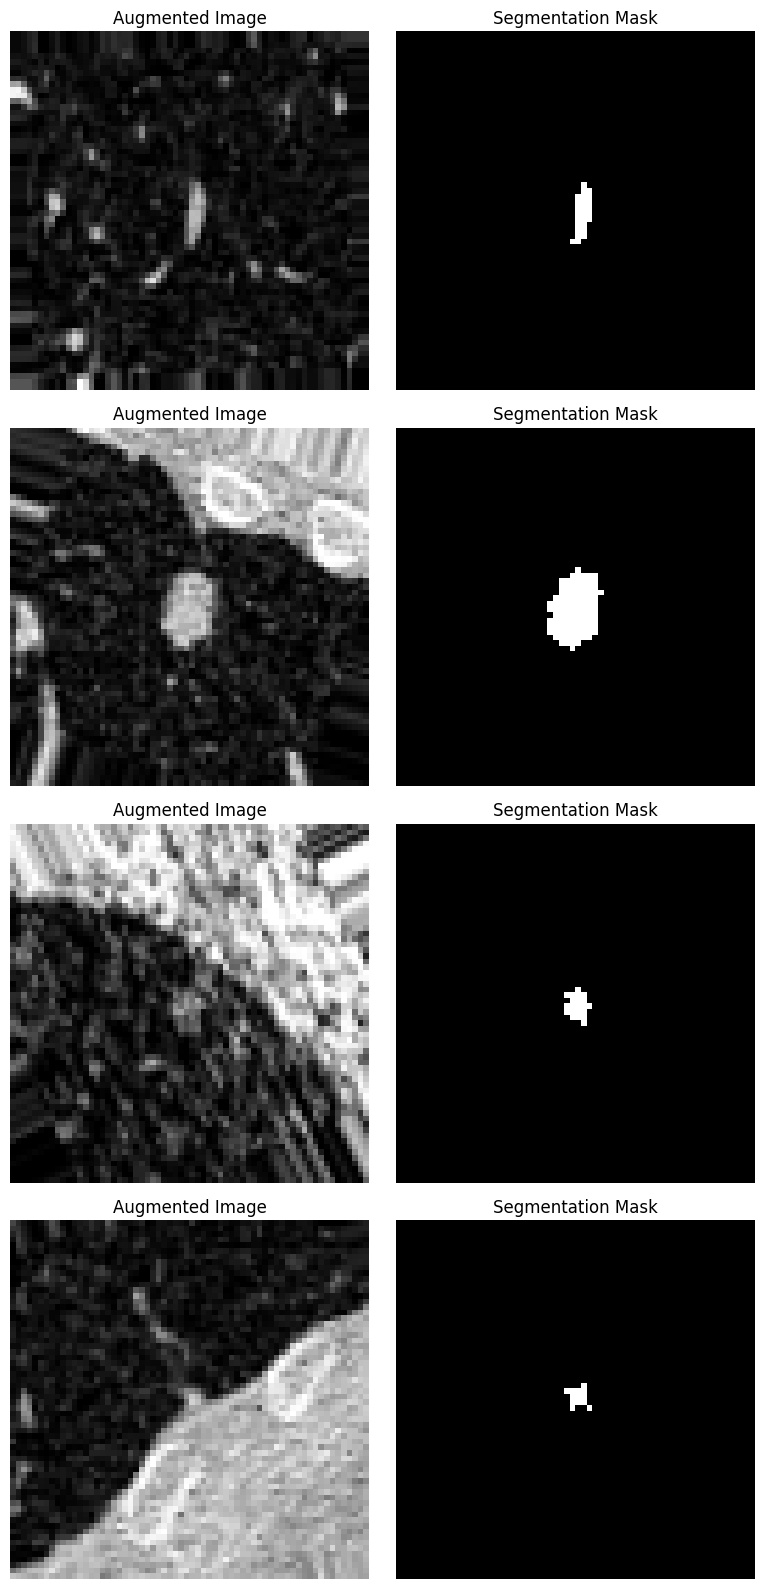

In [2]:
import matplotlib.pyplot as plt

def visualize_augmentations(loader, num_samples=3):
    """
    Visualize random samples with augmentation from the DataLoader.

    Parameters:
    - loader: DataLoader object.
    - num_samples: Number of samples to visualize.
    """
    batch = next(iter(loader))  # Get a batch
    
    # Move tensors to CPU and convert to numpy
    images = batch["image"].cpu().numpy()  # Convert to NumPy (Ensure it's on CPU)
    masks = batch["seg"].cpu().numpy()

    fig, axes = plt.subplots(num_samples, 2, figsize=(8, num_samples * 4))

    for i in range(num_samples):
        img = images[i, 0]  # Remove channel dim
        mask = masks[i, 0]

        # Show middle slice of the 3D volume
        mid_slice = img.shape[0] // 2

        axes[i, 0].imshow(img[mid_slice], cmap="gray")
        axes[i, 0].set_title("Augmented Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(mask[mid_slice], cmap="gray")
        axes[i, 1].set_title("Segmentation Mask")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()
# Example usage
visualize_augmentations(train_loader, num_samples=4)

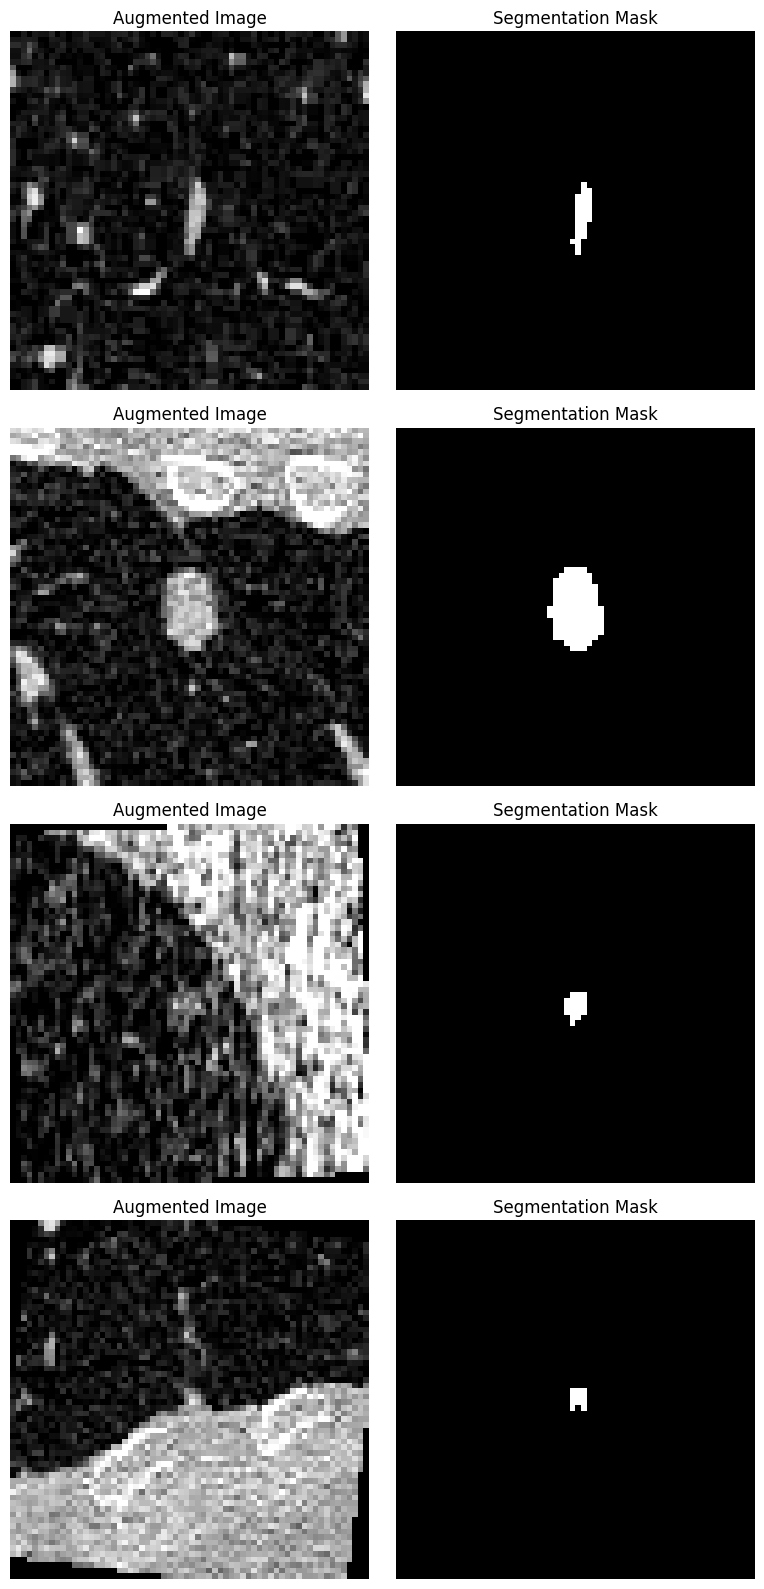

In [7]:
train_loader = load_lungAmbition(train, batch_size=4, spatial_size=[64, 64, 64], shuffle=False, type_processing = None, augment_prob=0)
visualize_augmentations(train_loader, num_samples=4)